# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["CS_frame_1_1"])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [3]:
"""

# test用にdfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

"""

'\n\n# test用にdfを期間で区切って小さくして使いたい時\nfrom_dt = datetime(2019, 1, 1)\nto_dt = datetime(2019, 9, 1)\n\nthe_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]\n\n'

In [3]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))
    
    # 展示競争の進入コース
    fv_list.append("exhibition_cource_{0}".format(i))
    
    
    # 直前のレースの成績
    # for j in range(1, 12):
        # fv_list.append("CS_frame_{0}_{1}".format(i, j))
        # fv_list.append("CS_rank_{0}_{1}".format(i, j))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

In [5]:
print(fv_label_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

In [6]:
print(fv_label_odds_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

1号艇についてtrainデータを使った正解率は0.6887257925249785,
           testデータを使った正解率は0.64354583393294
2号艇についてtrainデータを使った正解率は0.6763907734056988,
           testデータを使った正解率は0.6282918405525975
3号艇についてtrainデータを使った正解率は0.6643024546688048,
           testデータを使った正解率は0.6308821413152972
4号艇についてtrainデータを使った正解率は0.6720118416183545,
           testデータを使った正解率は0.6372139876241186
5号艇についてtrainデータを使った正解率は0.7071666461083015,
           testデータを使った正解率は0.677075838250108
6号艇についてtrainデータを使った正解率は0.7573084988281732,
           testデータを使った正解率は0.7455749028637214


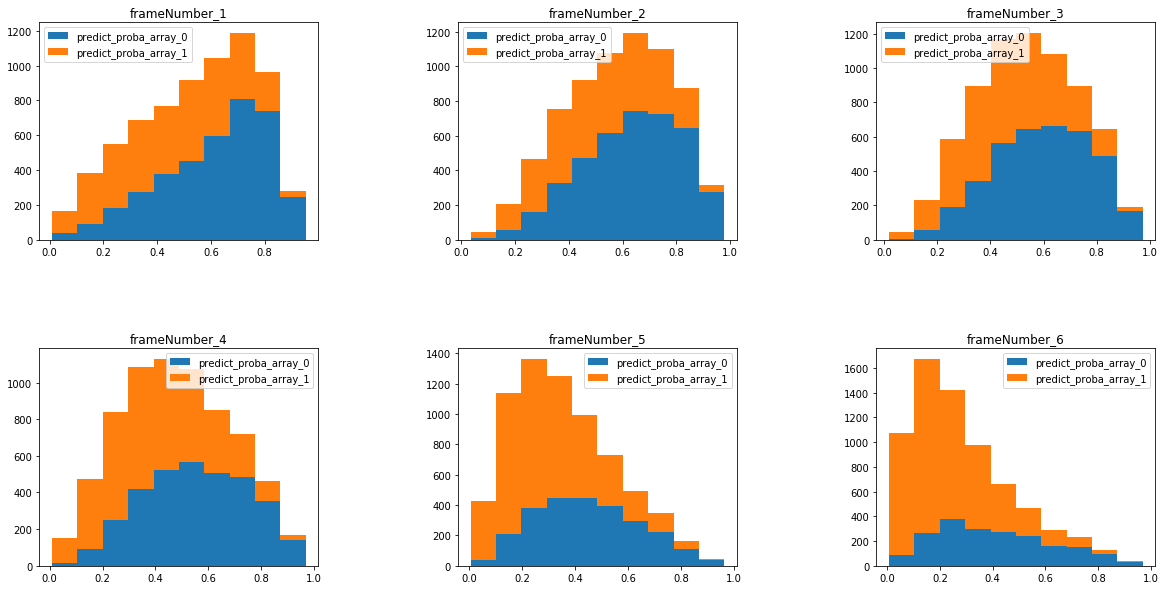

In [4]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))
    """
    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    # for j in range (coef.shape[1]):
        # print(fv_list[j], coef[0, j], "\n")
    """

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [8]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.802384    0.605297    0.744685    0.279773    0.030468    0.491383   
1       0.808262    0.892717    0.248234    0.394562    0.166098    0.187615   
2       0.252210    0.936119    0.244839    0.650338    0.130228    0.279777   
3       0.176668    0.876399    0.404914    0.435898    0.061979    0.757469   
4       0.422579    0.808984    0.322772    0.736416    0.332875    0.103465   
5       0.641812    0.552442    0.618877    0.675225    0.256918    0.101489   
6       0.505692    0.819516    0.486093    0.571623    0.113568    0.175055   
7       0.557837    0.617718    0.361242    0.304230    0.654766    0.164993   
8       0.633663    0.579706    0.480188    0.871510    0.208514    0.046755   
9       0.396425    0.595736    0.284457    0.436861    0.504721    0.560566   
10      0.264891    0.461846    0.671291    0.630755    0.303519    0.407937   
11      0.567532    0.896120    0.404955

In [9]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.7018204645323289, 回収率は0.9493408662900188
確率0.7以上で1に単勝betした場合、的中率は0.750613647520864, 回収率は0.9653411880216004
確率0.8以上で1に単勝betした場合、的中率は0.8146811070998796, 回収率は0.9602888086642599


In [10]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-55500, 回収率は0.8476948408342481
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-36670, 回収率は0.8392371766768961
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-16780, 回収率は0.8624590163934426
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-4820, 回収率は0.8963440860215054
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-36880, 回収率は0.8500813008130081
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-24640, 回収率は0.8368211920529801
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-13100, 回収率は0.83645443196005
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-4230, 回収率は0.8585284280936455
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-23740, 回収率は0.8334035087719298
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-12990, 回収率は0.8501730103806229
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-5880, 回収率は0.8669683257918552
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-1670, 回収率は0.8936305732484077


In [11]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-722580, 回収率は0.7586895538338231
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-406740, 回収率は0.7513814180929095
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-133300, 回収率は0.7904088050314465
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-390790, 回収率は0.7858450241122314
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-192620, 回収率は0.8026434426229508
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-56520, 回収率は0.8480645161290322
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-144380, 回収率は0.7918396770472895
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-58050, 回収率は0.8358314479638009
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-1430, 回収率は0.9886146496815287


In [12]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-993620, 回収率は0.7756862922160015
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-695160, 回収率は0.7825450450450451
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-493100, 回収率は0.7608168412883197
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-315210, 回収率は0.7266649323621228
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-116920, 回収率は0.7486672398968186
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-693830, 回収率は0.788621130879844
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-509190, 回収率は0.7833234042553191
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-343390, 回収率は0.7706452043815122
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-205700, 回収率は0.7485330073349633
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-69120, 回収率は0.7826415094339623
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-405080, 回収率は0.8032828282828283
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-320270, 回収率は0.7802757958287596
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-228390, 回収率は0.7496821569487067
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-110320, 回収率は0.7739344262295081
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-46860, 回収率は0.7480645161290322
p1が0.8以上かつ、p2

In [13]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-175240, 回収率は0.8533311014395715
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-128280, 回収率は0.8727885759619198
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-34340, 回収率は0.8889391979301423
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-98220, 回収率は0.8692840031940378
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-102070, 回収率は0.8472920406941951
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-24400, 回収率は0.8869323447636701
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-22070, 回収率は0.9262859051436205
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-31890, 回収率は0.8910116199589884
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-20790, 回収率は0.7788297872340425


In [14]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-645840, 回収率は0.8233479212253829
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-309600, 回収率は0.8440302267002519
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-140420, 回収率は0.8438736935734934
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-42820, 回収率は0.8594221930400525
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-5990, 回収率は0.9119117647058823
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は2040, 回収率は1.309090909090909
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-404430, 回収率は0.8489580221093517
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-208610, 回収率は0.8544445994976276
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-74160, 回収率は0.8835061262959473
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-23330, 回収率は0.8885864374403056
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-50, 回収率は0.9988636363636364
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は2750, 回収率は1.5729166666666667
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-241210, 回収率は0.8533142787642909
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-110900, 回収率は0.8730830853742275
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-29330, 回収率は0.9218700053276505
p1が0.7以上かつ、p2-6が0.6以上で3連単be

In [15]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-237370, 回収率は0.8558423417952143
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-144840, 回収率は0.873744769874477
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-83440, 回収率は0.8870906630581867
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-46660, 回収率は0.8885864374403056
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-140300, 回収率は0.8350576063954855
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-83680, 回収率は0.8528315160042209
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-33260, 回収率は0.9062041737168641
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-17420, 回収率は0.9119312436804854
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-100, 回収率は0.9988636363636364
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-31660, 回収率は0.8967384213959556
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-5340, 回収率は0.9726153846153847
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は3290, 回収率は1.0287085514834207
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は2200, 回収率は1.0361842105263157
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は8670, 回収率は1.3284090909090909
p1が0.6以上かつ、p2

In [16]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、2-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "2-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-50810, 回収率は0.8175583482944345
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-41450, 回収率は0.7580268534734385
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-6480, 回収率は0.9178707224334601
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-36230, 回収率は0.7489258489258489
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-24650, 回収率は0.709658421672556
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-3780, 回収率は0.8938202247191012
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-40510, 回収率は0.5523756906077348
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-24870, 回収率は0.5342696629213484
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4000, 回収率は0.8190045248868778
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-15640, 回収率は0.5691460055096419
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-8040, 回収率は0.6039408866995074
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-830, 回収率は0.8975308641975308


In [17]:
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-237370, 回収率は0.8558423417952143
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-144840, 回収率は0.873744769874477
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-83440, 回収率は0.8870906630581867
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-46660, 回収率は0.8885864374403056
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-140300, 回収率は0.8350576063954855
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-83680, 回収率は0.8528315160042209
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-33260, 回収率は0.9062041737168641
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-17420, 回収率は0.9119312436804854
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-100, 回収率は0.9988636363636364
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-31660, 回収率は0.8967384213959556
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-5340, 回収率は0.9726153846153847
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は3290, 回収率は1.0287085514834207
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は2200, 回収率は1.0361842105263157
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は8670, 回収率は1.3284090909090909
p1が0.6以上かつ、p2

In [18]:
# 1号艇の勝率x_1以上,3号艇の勝率x_2以上のとき、3-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_3".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "3-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-39730, 回収率は0.8163199260286639
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-27060, 回収率は0.7791020408163265
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-19400, 回収率は0.6290630975143403
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-32420, 回収率は0.7009225092250922
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-17990, 回収率は0.6996661101836394
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-8660, 回収率は0.6465306122448979
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-20040, 回収率は0.6972809667673716
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-7660, 回収率は0.7848314606741573
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-3880, 回収率は0.7188405797101449
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-10840, 回収率は0.5955223880597015
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-5310, 回収率は0.6179856115107913
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-2890, 回収率は0.43333333333333335


In [19]:
# 1号艇の勝率x_1以上,4号艇の勝率x_2以上のとき、4-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_4".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "4-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-58240, 回収率は0.625706940874036
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-31470, 回収率は0.644406779661017
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-13610, 回収率は0.6144475920679887
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-33190, 回収率は0.5655759162303665
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-15720, 回収率は0.6248210023866348
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4660, 回収率は0.687248322147651
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-26280, 回収率は0.4396588486140725
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-14120, 回収率は0.42834008097165993
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1240, 回収率は0.8590909090909091
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-8550, 回収率は0.4020979020979021
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-3610, 回収率は0.4915492957746479
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-420, 回収率は0.8090909090909091


In [20]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、1-2にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "1-2":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-51560, 回収率は0.8148653500897666
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-36000, 回収率は0.7898423817863398
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-20690, 回収率は0.7377693282636248
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-17140, 回収率は0.8812196812196812
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-13350, 回収率は0.842756183745583
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-8110, 回収率は0.772191011235955
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-9470, 回収率は0.8953591160220995
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-5490, 回収率は0.897191011235955
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4380, 回収率は0.8018099547511313
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-3140, 回収率は0.9134986225895316
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-2180, 回収率は0.8926108374384236
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1530, 回収率は0.8111111111111111


In [21]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のときで、x_3を超えている他の艇に対して2-1-XXにbet
x_1_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.2, 0.3, 0.4, 0.5, 0.6]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    if row["PredProb_2".format(j)] > x_2:
                        for i in range(3, 7):
                            if row["PredProb_{0}".format(i)] > x_3:
                                bet = bet + 100

                                if row["trifecta"] == "2-1-{0}".format(i):
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1 > {0}、p2 > {1}, p3 > {2}で3連単2-1-i にbetすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income / bet) < 1:
                    text = termcolor.colored(text, "red")
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1 > 0.3、p2 > 0.6, p3 > 0.2で3連単2-1-i にbetすると収益は-114420, 回収率は0.8635583114715001
p1 > 0.3、p2 > 0.6, p3 > 0.3で3連単2-1-i にbetすると収益は-69300, 回収率は0.891955098222638
p1 > 0.3、p2 > 0.6, p3 > 0.4で3連単2-1-i にbetすると収益は-45520, 回収率は0.9005462093074066
p1 > 0.3、p2 > 0.6, p3 > 0.5で3連単2-1-i にbetすると収益は-29810, 回収率は0.8998992612491605
p1 > 0.3、p2 > 0.6, p3 > 0.6で3連単2-1-i にbetすると収益は-19210, 回収率は0.8873313782991202
p1 > 0.3、p2 > 0.7, p3 > 0.2で3連単2-1-i にbetすると収益は-114600, 回収率は0.7697408077154912
p1 > 0.3、p2 > 0.7, p3 > 0.3で3連単2-1-i にbetすると収益は-99010, 回収率は0.7354088722608231
p1 > 0.3、p2 > 0.7, p3 > 0.4で3連単2-1-i にbetすると収益は-49970, 回収率は0.8075115562403699
p1 > 0.3、p2 > 0.7, p3 > 0.5で3連単2-1-i にbetすると収益は-37520, 回収率は0.7703794369645043
p1 > 0.3、p2 > 0.7, p3 > 0.6で3連単2-1-i にbetすると収益は-7450, 回収率は0.9203208556149732
p1 > 0.3、p2 > 0.8, p3 > 0.2で3連単2-1-i にbetすると収益は-13400, 回収率は0.9392840960579972
p1 > 0.3、p2 > 0.8, p3 > 0.3で3連単2-1-i にbetすると収益は-24450, 回収率は0.8483250620347395
p1 > 0.3、p2 > 0.8, p3 > 0.4で3連単2-1-i にbetすると収益は-7770, 回収率は0.9285

### x_2 > 0.8 さえ入れればほとんどのx_1, x_3でプラスになるぞおおおおおお
### x_1 > 0.4, x_2 > 0.8, x_3 > 0.6を満たすレースへbetしていってみる探す